# TKT4108 - Structural Dynamics 2
## Homework 3 - Solution

### Part A Take a uniform soil layer with thickness 30 m, $V_{s}$ =150 m/s and $\rho$ = 1800 $\frac{kg}{m^3}$ over a rigid base.

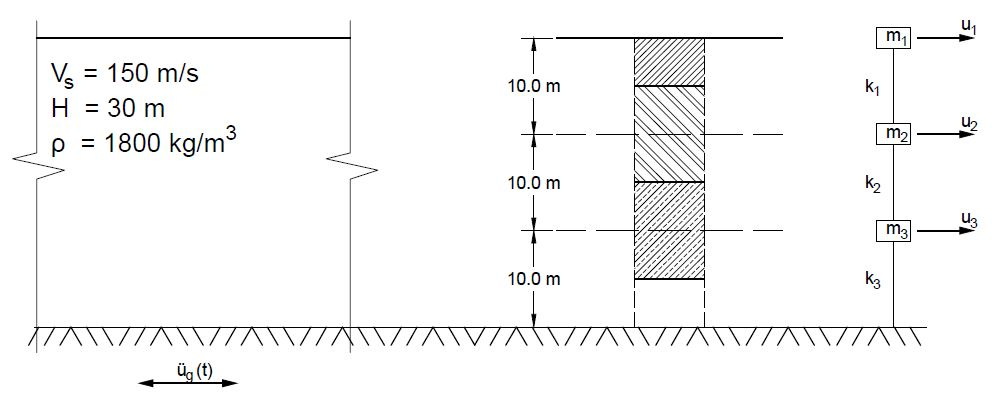

**1) Compute the three natural frequencies of the soil layer using a 3DOF shear beam model and compare with theoretical solution.**  
**2) Consider that the base (bedrock) is excited by an earthquake with EC8 response spectrum with $a_g$ =  1 m/s 2 . Establish the soil factor, S , by computing the maximum acceleration on the ground surface using mode superposition method, and compare with the soil factor, S , for ground type D. For this question, use the analytical solution for a uniform soil layer to establish the mode shapes, and compute the corresponding natural frequencies on that basis.**

In [1]:
import numpy as np

import scipy.linalg as linalg
import matplotlib.pyplot as plt


# Soil Properties
V_s = 150                   # shear wave velocity in m/s
H = 30.0                    # total height of soil layer in m
rho = 1800.0                # soil density in kg/m3
T = [1,1,1]                 # influence vector
a_g = 1.0                   # ground acceleration in m/s2

G_s = rho*(V_s**2)          # shear modulus in Pa (assuming an area of 1 m2)

### Part A1
The soil sub-layer mass and stiffness are first computed. Then, the system stiffness and mass matrices are assembled and the eigenvalue solution is applied obtaining natural frequencies

In [2]:
# Soil sub-layers mass and stiffness
m = np.array([5,10,10])*rho     # mass of each sub-layer (assuming an area of 1 m2)
k = G_s/(H/3)                   # stifness of each sub-layer

# System Matices
K = k * np.array([[1,-1,0],[-1,2,-1],[0,-1,2]])     # stifnees matrix
M = np.array([[m[0],0,0],[0,m[1],0],[0,0,m[2]]])    # mass matrix

# Eigenvale Analysis
lambd, phi = linalg.eig(K, b=M)   
wn = np.sqrt(np.sort(lambd.real))    # natural circular frequency
fn = wn/(2*np.pi)           # natural frequency
Tn = 1/fn                   # natural period

print('The natural frequencies are')
print(str(np.around(fn,2)) + ' Hz')
print( )
print('Then, the natural periods are')
print(str(np.around(Tn,3)) + ' s')
print( )

The natural frequencies are
[1.24 3.38 4.61] Hz

Then, the natural periods are
[0.809 0.296 0.217] s



The theoretical frequencies of a uniform soil layer are
$$f_i = (2i-1)\frac{V_s}{4H}$$
where $V_s$ is the shear wave velocity of the soil and $H$ is the thickness of the uniform soil layer

In [3]:
# Theoretical frequencies
fn_theory = (V_s/(4*H)) * (2*np.array([1,2,3])-1)       # See Kramer p.257 or lecture notes
print('The theoretical natural frequencies are')
print(str(np.around(fn_theory,2)) + ' Hz')

The theoretical natural frequencies are
[1.25 3.75 6.25] Hz


### Part A2
Given the differential equation of motion of the soil layer with solution:
$$\bar{u}=A\ cos\left(\frac{\omega}{V_s}z\right) + B\ sin\left(\frac{\omega}{V_s}z\right)$$
with $z = 0$ at the bottom of soil layer.  
Non-trivial solution for free vibation (no external excitation) is possible only if:  
$$A = 0\ and\ \frac{\omega H}{V_s} = (2n-1)\frac{\pi}{2}\ ,n=1,2,3...$$
Then, the natural circular frequencies are:
$$\omega_n = (2n-1)\frac{\pi}{2}\frac{V_s}{H}$$
and corresponsing mode shapes:
$$\phi_{n}(z) = sin\left((2n-1)\frac{\pi}{2}\frac{z}{H}\right)$$

In [4]:
# Theoretical modes
z = (H/3)*np.array([1,2,3])
phi = np.sin((2*np.array([1,2,3])-1)*(np.pi/2)*(np.reshape(z,(len(z),1))/H))   # non-trivial solutions to diff. equation
phi = np.flipud(phi)          # DOF 1 is located where z/H is 1

print('Thepretical mode shapes')
print(np.around(phi,3))

Thepretical mode shapes
[[ 1.    -1.     1.   ]
 [ 0.866  0.    -0.866]
 [ 0.5    1.     0.5  ]]


Natural frequencies for given mode shapes and system matrices (stiffness and mass) can be calculated by Rayleigh Quotient (see Chopra section 8.5.3)
$$\omega_i = \frac{\phi_{i}^{T} K \phi_{i}}{\phi_{i}^{T} M \phi_{i}}$$  
The modal participation factor is calculated by
$$\gamma_i = \frac{\phi_{i}^{T} K\  T}{\phi_{i}^{T} M \phi_{i}}$$

In [5]:
# Rayleigh quotient and modal properties
wn_ray = np.sqrt(np.diag((phi.T @ K @phi))/np.diag(phi.T @ M @phi))    # See Chopra Section 8.5.3
Tn_ray = 2*np.pi/wn_ray
gamma_mod = (phi.T @ M @T)/np.diag(phi.T @ M @phi)  

print('The natural circular frequencies by Rayleigh quotient are')
print(str(np.around(wn_ray,2)) + ' rad/s')
print( )
print('The modal participation factors are')
print(np.around(gamma_mod,3))
print( )

The natural circular frequencies by Rayleigh quotient are
[ 7.76 21.21 28.98] rad/s

The modal participation factors are
[1.244 0.333 0.089]



The response spectrum is plotted and the corresponding normalized accelerations for each natural period are obtained

(0.0, 2.75)

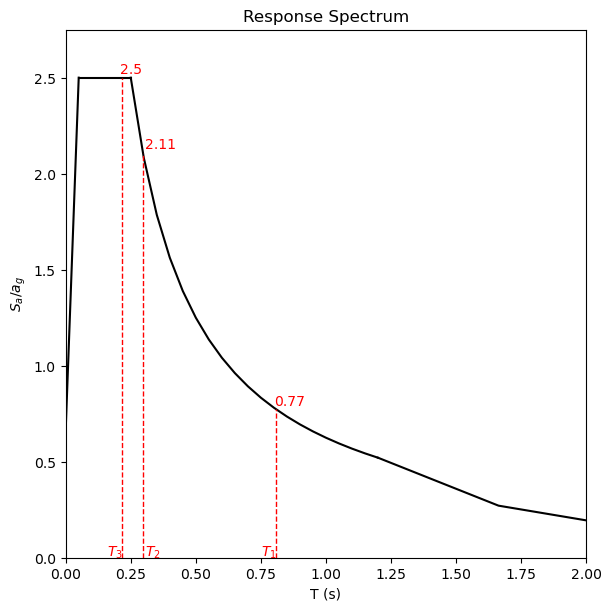

In [6]:
# Response Spectrum
T_spectrum = [0,0.05,0.25,1.2,10]       # Spectrum Parameters for A-type soil
S_0 = 1                                 # Spectrum Parameters for A-type soil
q = 1
resp_spectrum = [lambda t: S_0*(2/3 + (t/T_spectrum[1])*(2.5/q - 2/3)),
                 lambda t: S_0*(2.5/q) if (isinstance(t, float)) else S_0*(2.5/q)*np.ones(len(t)),
                 lambda t: S_0*(2.5/q)*(T_spectrum[2]/t),
                 lambda t: S_0*(2.5/q)*((T_spectrum[2]*T_spectrum[3])/(t**2))]

# Seismic Response
S_a = np.zeros(Tn.shape)
for i_mode,Tn_i in enumerate(Tn_ray):
    if Tn_i < T_spectrum[1]: 
        S_a[i_mode] = a_g * resp_spectrum[0](Tn_i)
    elif Tn_i > T_spectrum[1] and Tn_i < T_spectrum[2]:
        S_a[i_mode] = a_g * resp_spectrum[1](Tn_i)
    elif Tn_i > T_spectrum[2] and Tn_i < T_spectrum[3]:
        S_a[i_mode] = a_g * resp_spectrum[2](Tn_i)
    elif Tn_i > T_spectrum[3]:
        S_a[i_mode] = a_g * resp_spectrum[3](Tn_i)
        # Plotting the response spectrum
plt.figure(figsize=(6.00, 6.00),constrained_layout=True)
for i_curve in range(len(resp_spectrum)):
    t = np.linspace(T_spectrum[i_curve],T_spectrum[i_curve+1],20,endpoint=True)
    S_norm = resp_spectrum[i_curve](t)
    plt.plot(t,S_norm,'-k',lw=1.5)
for i_mode,Tn_i in enumerate(Tn_ray):
        plt.vlines(x=Tn_i, ymin=0, ymax=S_a[i_mode]/a_g, color='red', linestyle='--',lw=1)
        if i_mode % 2 == 0:
            plt.text(x=Tn_i-0.06, y=0.01, s='$T_{'+str(i_mode+1)+'}$', fontsize=10,color='red')
            plt.text(x=Tn_i-0.01, y=S_a[i_mode]/a_g+0.02, s=str(np.round(S_a[i_mode]/a_g,2)), fontsize=10,color='red')
        else:
            plt.text(x=Tn_i+0.01, y=0.01, s='$T_{'+str(i_mode+1)+'}$', fontsize=10,color='red')
            plt.text(x=Tn_i+0.01, y=S_a[i_mode]/a_g+0.02, s=str(np.round(S_a[i_mode]/a_g,2)), fontsize=10,color='red')
plt.title('Response Spectrum')
plt.xlabel('T (s)')
plt.ylabel('$S_{a}/a_{g}$')
plt.xlim([0,2])
plt.ylim([0,1.1*resp_spectrum[1](T_spectrum[1])])

Having obtained the maximum acceleration responses with the response spectrum, the modal analysis and combination is done

In [7]:
# Modal Analysis
Fs_max = gamma_mod*S_a*(M @ phi)                # max forces in each DOF for each mode
Fs_top_max = np.sqrt(np.sum(Fs_max[0,:]**2))    # combined force at top floor by SRSS

print('The maximum forces at each degree of freedom (rows) per mode (columns) are')
print(str(np.around(Fs_max,2)) +' N')
print( )
print('The maximum force at the top degree of freedom combined by use of SRSS is')
print(str(np.around(Fs_top_max,2)) +' N')
print( )

The maximum forces at each degree of freedom (rows) per mode (columns) are
[[ 8647.42 -6330.35  2009.62]
 [14977.77     0.   -3480.76]
 [ 8647.42 12660.7   2009.62]] N

The maximum force at the top degree of freedom combined by use of SRSS is
10903.66 N



Finally, the acceleration at the top floor is computed and the ratio of this result divided by the acceleration at the support can be compared to the soil factor S.

In [8]:
# Acceleration at top
a_top = Fs_top_max/m[0]
S_modal = a_top/a_g

print('The maximum acceleration at the top is')
print(str(np.around(a_top,2)) +' m/s2')
print( )
print('The ratio to compare with soil factor S = 1.55 for D type soil is')
print(str(np.around(S_modal,2)))
print( )

The maximum acceleration at the top is
1.21 m/s2

The ratio to compare with soil factor S = 1.55 for D type soil is
1.21



### Part B: Consider a 8-storey shear-type concrete building with the following parameters: m = 8 tons, floor height = 3 m, and k (total stiffness of each floor) = 10,000 kN/m
**1) Assuming a linear variation for the first mode ( i.e. $\phi_1 = [0.8\ \  0.7\ \  0.6\  ... 0.1]^{T}$ ), compute the first natural period of the building.**  
**2) By replacing the building with a continuous shear beam (like a uniform soil column), compute the first natural period of the building and compare it with the result of eight DOF  (Hint: natural frequency of a uniform soil column is $\frac{V_s}{4H}$ with $V_{s}^2 = \frac{G}{\rho}$**

In [9]:
# Building Properties
k = 10e+6       # stifness in N/m units
m = 8e+3        # mass in kg
L = 3.00        # height between storeys
n_dofs = 8      # number of storeys

# Assumed first mode shape
phi_1 = np.arange(n_dofs,0,-1)/10

### Part B1
The system stiffness and mass matrices are assembled and the first natural frequency an period are obtained via Rayleigh Quotient (see Chopra section 8.5.3)

In [10]:
# System Matices
M = m*np.eye(n_dofs)
M[0,0] = 0.5*M[0,0]

K = (2*k)*np.eye(n_dofs) + (-k)*np.eye(n_dofs,k=1) + (-k)*np.eye(n_dofs,k=-1)
K[0,0] = 0.5*K[0,0]

# Rayleigh quotient and modal properties
wn_1 = np.sqrt((phi_1.T @ K @phi_1)/(phi_1.T @ M @phi_1))    # See Chopra Section 8.5.3
Tn_1 = 2*np.pi/wn_1

print('The first natural circular frequency by Rayleigh quotient is')
print(str(np.around(wn_1,2)) + ' rad/s')
print( )
print('Then, the fundamental period by Rayleigh quotient is')
print(str(np.around(Tn_1,2)) + ' s')
print( )

The first natural circular frequency by Rayleigh quotient is
7.62 rad/s

Then, the fundamental period by Rayleigh quotient is
0.82 s



### Part B2
Considering a cross sectional area of $1 m^2$ a continous shear beam will have the following parameters ($h$ being the height between floors):
$$\rho = \frac{m}{h}\ ,\ G = k\ h$$

In [11]:
# Continous shear beam parameters
rho = m/L                   # assuming an area of 1 m2
G = k*L                     # for small gamma angles
V_s = np.sqrt(G/rho)        # shear wave velocity in m/s

# Theoretical frequency
fn_1_theory = V_s/(4*(n_dofs*L))          # See Kramer p.257 or lecture notes
Tn_1_theory = 1/fn_1_theory

print('The first natural period of a continous shear beam is')
print(str(np.around(Tn_1_theory,2)) + ' s')


The first natural period of a continous shear beam is
0.91 s
